<a href="https://colab.research.google.com/github/nerobite/neural_networks/blob/main/Thematic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Классификация по тональности
В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.


In [2]:
import json
import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('/content/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:56, 1725.76it/s]


In [ ]:
responses[:2]

[{'city': 'г. Москва',
  'rating_not_checked': False,
  'title': 'Жалоба',
  'num_comments': 0,
  'bank_license': 'лицензия № 2562',
  'author': 'uhnov1',
  'bank_name': 'Бинбанк',
  'datetime': '2015-06-08 12:50:54',
  'text': 'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом 

In [4]:
df = pd.DataFrame(responses)

In [ ]:
df.head()

city  rating_not_checked  \
0       г. Москва               False   
1  г. Новосибирск               False   
2       г. Москва               False   
3   г. Ставрополь               False   
4    г. Челябинск               False   

                                               title  num_comments  \
0                                             Жалоба             0   
1      Не могу пользоваться услугой Сбербанк он-лайн             0   
2                    Двойное списание за один товар.             1   
3  Меняют проценты комиссии  не предупредив и не ...             2   
4             Верните денежные средства за страховку             1   

      bank_license       author        bank_name             datetime  \
0  лицензия № 2562       uhnov1          Бинбанк  2015-06-08 12:50:54   
1  лицензия № 1481       Foryou  Сбербанк России  2015-06-08 11:09:57   
2  лицензия № 2562   Vladimir84          Бинбанк  2015-06-05 20:14:28   
3  лицензия № 1481       643609  Сбербанк России  2015-06-05 13:51:01   
4  лицензия № 2766  anfisa-2003         ОТП Банк  2015-06-05 10:58:12   

                                                text  rating_grade  
0  Добрый день! Я не являюсь клиентом банка и пор...           NaN  
1  Доброго дня! Являюсь держателем зарплатной кар...           NaN  
2  Здравствуйте!  Дублирую свое заявление от 03.0...           NaN  
3  Добрый день!! Я открыл расчетный счет в СберБа...           NaN  
4  04.03.2015 г. взяла кредит в вашем банке, заяв...           NaN

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [5]:
df_text = df.iloc[df.index < 5000]

Часть 1. Анализ текстов

1. Посчитайте количество отзывов в разных городах и на разные банки

In [ ]:
df.city.value_counts()

city
г. Москва                               55354
г. Санкт-Петербург                      14342
г. Екатеринбург                          2337
г. Новосибирск                           2300
г. Нижний Новгород                       1976
                                        ...  
г. г.Калуга                                 1
г. ВЕЛИКИЕ ЛУКИ                             1
г. всеволожск                               1
г. сейчас                                   1
г. Краснодарский край, ст.Павловская        1
Name: count, Length: 5823, dtype: int64

In [ ]:
df.bank_name.value_counts()

bank_name
Сбербанк России     26327
Альфа-Банк          10224
ВТБ 24               8185
Русский Стандарт     7943
Хоум Кредит Банк     7549
                    ...  
Сиббизнесбанк           1
Донбанк                 1
Потенциал               1
Ури Банк                1
БайкалИнвестБанк        1
Name: count, Length: 670, dtype: int64

In [ ]:
result = df['city'].groupby(df['bank_name']).value_counts()

print(result)

bank_name      city                        
2Т Банк        г. Москва                       359
               г. Санкт-Петербург              163
               г. Краснодар                     11
               г. Новороссийск                  10
               г. Нижний Новгород                7
                                              ... 
Яндекс.Деньги  г. Сочи (Краснодарский край)      1
               г. Стамбул                        1
Ярославич      г. Москва                         2
               г. Ярославль                      2
               г. Рыбинск                        1
Name: count, Length: 18769, dtype: int64


In [ ]:
result1 = df['bank_name'].groupby(df['city']).value_counts()

print(result1)

city                                     bank_name                     
г.  (Красногорск)                        Транснациональный Банк            1
г.  (Москва)                             Райффайзенбанк                    1
                                         Национальный Банк «Траст»         1
г.  (Россия)                             Кредит-Москва                     1
г.  (Ханты-Мансийский автономный округ)  Киви Банк                         1
                                                                          ..
г. ярославль                             Ханты-Мансийский банк Открытие    1
                                         Хоум Кредит Банк                  1
г. ярцево                                Национальный Банк «Траст»         1
                                         Сбербанк России                   1
г. … или другой населенный пункт         Лето Банк                         1
Name: count, Length: 18769, dtype: int64


In [ ]:
result2 = df.groupby(['city', 'bank_name']).size().reset_index(name='counts')



In [ ]:
result2.sort_values('counts', ascending=False, inplace=True)
result2 = result2.reset_index()
result2

index                                 city                  bank_name  \
0       7453                            г. Москва            Сбербанк России   
1       7160                            г. Москва                 Альфа-Банк   
2       7437                            г. Москва           Русский Стандарт   
3       7206                            г. Москва                     ВТБ 24   
4      12394                   г. Санкт-Петербург            Сбербанк России   
...      ...                                  ...                        ...   
18764   7733  г. Москва,  Отделение "Жулебинское"  Московский Кредитный Банк   
18765   7734             г. Москва, "Китай-город"                  Фора-Банк   
18766   7735              г. Москва, Ветошный пер    Восточный Экспресс Банк   
18767   7736                    г. Москва, Видное            Сбербанк России   
18768  18768     г. … или другой населенный пункт                  Лето Банк   

       counts  
0        8146  
1        3871  
2        2801  
3        2714  
4        2434  
...       ...  
18764       1  
18765       1  
18766       1  
18767       1  
18768       1  

[18769 rows x 4 columns]

2. Постройте гистограмы длин слов в символах и в словах

In [ ]:
text = []
for t in df['text']:
  text.append(t)

In [ ]:
text[:2]

['Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор, мне по меньшей мере не понятно,\xa0 и почему по Вашей милости я должна переживать и бояться за себе и свое имущество. Письма доставляют м

In [ ]:
words = ' '.join(text)

In [ ]:
len(words)

238723607

In [ ]:
words[:1000]

'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор, мне по меньшей мере не понятно,\xa0 и почему по Вашей милости я должна переживать и бояться за себе и свое имущество. Письма доставляют мн

In [ ]:
words = re.sub(r'[,.!?-\xa0"№0-9()]', ' ', words)


In [ ]:
words[:1000]

'Добрый день  Я не являюсь клиентом банка и поручителем по кредитному договору  а также не являюсь каким-либо другим лицом  письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности   Начиная с марта      года начали приходить бесконечные письма из ООО  Примо коллект на мой адрес: город Москва  Уваровский переулок  дом     квартира      с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича  который уклоняется от уплаты взятых им кредитов: договор         от            года и договор           от            года  Со всей ответственностью  хочу Вас заверить  что вышеуказанный гражданин  которого Вы разыскиваете  мне не знаком и никогда в моем адресе не был зарегистрирован  Каким образом Вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор  мне по меньшей мере не понятно   и почему по Вашей милости я должна переживать и бояться за себе и свое имущество  Письма доставляют мне серь

In [ ]:
words = words.lower()
words = words.split()

In [ ]:
len(words)

35624492

In [ ]:
words = words[:1000000]

In [ ]:
# Подсчет длин слов в символах
word_lengths_in_chars = [len(word) for word in words]

In [ ]:
max(word_lengths_in_chars)

84

In [ ]:
word_lengths = pd.DataFrame(word_lengths_in_chars)

In [ ]:
word_lengths.loc[word_lengths[0] <30].value_counts()

1     138404
5     117561
3     110966
6     105914
2     103573
7      86712
4      78200
8      76985
9      68443
10     43292
11     27271
12     17539
13     11357
14      6252
15      3645
16      2041
17       693
18       501
19       240
20       125
22        65
21        61
24        57
23        43
25        20
26        14
27        10
29         4
28         3
Name: count, dtype: int64

In [ ]:
word_lengths_less_20 = word_lengths.loc[word_lengths[0] <= 20]

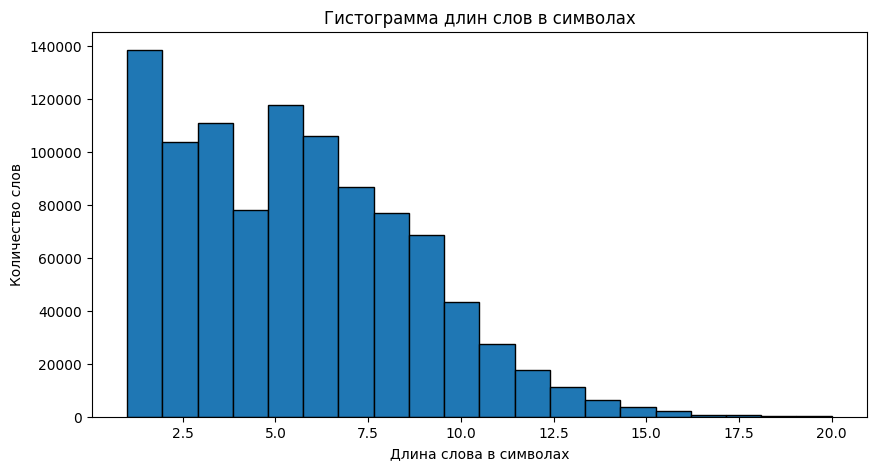

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(word_lengths_less_20, bins=20, edgecolor='black')
plt.title('Гистограмма длин слов в символах')
plt.xlabel('Длина слова в символах')
plt.ylabel('Количество слов')
plt.show()

In [ ]:
# #освобождаем память
import gc
gc.collect()

4734

In [ ]:
# # Подсчет длин слов в словах
# word_lengths_in_words = [len(word) for word in words]

In [ ]:
# # Создание гистограммы длин слов в словах
# plt.figure(figsize=(10, 5))
# plt.hist(word_lengths_in_words, bins=range(1, max(word_lengths_in_words) + 2), edgecolor='black')
# plt.title('Гистограмма длин слов в словах')
# plt.xlabel('Длина слова в словах')
# plt.ylabel('Количество слов')
# plt.show()

3. Найдите 10 самых частых:

*   слов
*   слов без стоп-слов
*   лемм
*   существительных


In [ ]:
df_words = pd.DataFrame(words)

In [ ]:
top_ten = df_words.value_counts()[:10]
top_ten

в      36505
и      29791
не     24494
на     19944
что    17241
я      16417
с      13619
по     10961
мне     9278
-       8743
Name: count, dtype: int64

In [10]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import pymystem3
m = pymystem3.Mystem()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [11]:
mystopwords = stopwords.words('russian') + [
    'что', 'мне' , '-', 'в', 'т', 'я', 'г'
]

ru_words = re.compile("[А-Яа-я]+")


def words_only(text):
    return " ".join(ru_words.findall(text))

def lemmatize(text, mystem=m):
    try:
        return " ".join([m.lemmatize(w)[0] for w in text.split(' ')]).strip()
    except:
        return " "

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""


def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [ ]:
words2 = ' '.join(text)
text2 = words_only(words2)

In [ ]:
# #освобождаем память
gc.collect()

7

In [ ]:
text2 = text2[:1000000]
text2 = text2.lower()

In [ ]:
top_ten_stop = remove_stopwords(text2)
top_ten_stop2 = remove_stopwords(text2)

In [ ]:
top_ten_stop = top_ten_stop.split()

In [ ]:
top_ten_stop = pd.DataFrame(top_ten_stop)
top_ten_stop.value_counts()[:11]

банка        1383
банк         1135
это           814
деньги        537
карты         451
карту         418
кредит        380
день          328
банке         325
года          310
заявление     288
Name: count, dtype: int64

In [ ]:
top_ten_lemmatize = lemmatize(top_ten_stop2)

In [ ]:
top_ten_lemmatize = top_ten_lemmatize.split()

In [ ]:
top_ten_lemmatize = pd.DataFrame(top_ten_lemmatize)
top_ten_lemmatize.value_counts()[:11]

банк       1841
банка      1546
карта      1407
это         922
кредит      823
мой         771
вклад       739
который     718
деньги      714
день        667
клиент      661
Name: count, dtype: int64

In [ ]:
pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 53.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=26ed9d77b116c6733fdce0907c6ecfc6d1fae6cf05e045db994e15807dedd11a
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
import pymorphy2
# Создаем экземпляр морфологического анализатора
morph = pymorphy2.MorphAnalyzer()

In [ ]:
def noun_words(text):
  try:
    return " ".join([word for word in words if morph.parse(word)[0].tag.POS == 'NOUN']).strip()
  except:
    return " "

In [ ]:
t = preprocess(text2)

In [ ]:
t

'добрый день являться клиент банка поручитель кредитный договор также являться какой либо другой лицо письменно оформлять отношение банк повод урегулирование чей либо задолженность начинать март год начинать приходить бесконечный письмо ооо примо коллект адрес город москва уваровский переулок дом квартира угроза возбуждение уголовный дело отношение гражданин филиппов эдуард владимирович который уклоняться уплата взять кредит договор год договор год весь ответственность хотеть заверять вышеуказанный гражданин который разыскивать знак мой адрес зарегистрировать какой образ удостоверяться подлинность документ оформлять имя кредитный договор меньший мера понятно почему ваш милость должный переживать бояться свое имущество письмо доставлять серьезный неудобство нарушать мой гражданский право также нарушать закон защита персональный данный убедительно просить прекращать посылать адрес письмо угроза вопрос который иметь отношение случай отклонение мой претензия быть вынуждать обращаться жалоб

In [ ]:
top_noun_words = noun_words(t)

In [ ]:
top_noun_words = top_noun_words.split()

In [ ]:
top_noun_words = pd.DataFrame(top_noun_words)
top_noun_words.value_counts()[:11]

банка        8049
банк         6125
деньги       3385
карты        2992
карту        2867
день         2362
кредит       2293
г            2069
раз          1893
заявление    1880
банке        1840
Name: count, dtype: int64

4. Постройте кривые Ципфа и Хипса

In [ ]:
from collections import Counter

In [ ]:
words = text2.split()
word_counts = Counter(words)

In [ ]:
# Подсчет длин слов
word_lengths = [len(word) for word in words]
# Подсчет частоты слов каждой длины
length_counts = Counter(word_lengths)

In [ ]:
# Сортировка длин слов по частоте
sorted_lengths = sorted(length_counts.items(), key=lambda x: x[1], reverse=True)

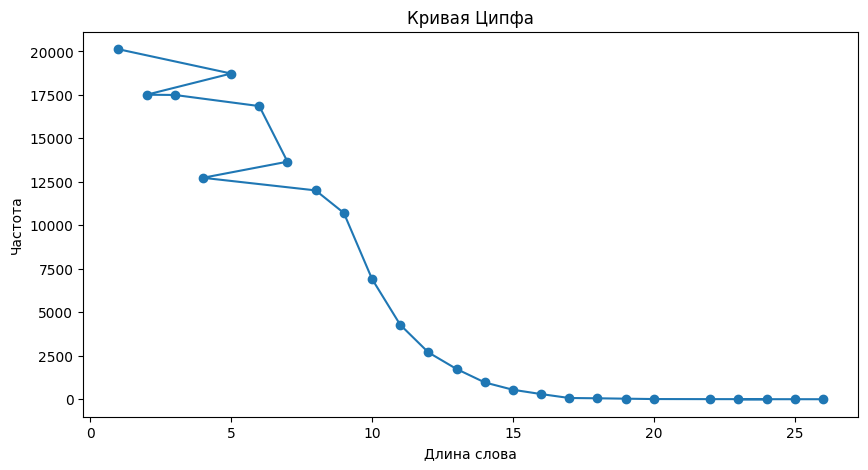

In [ ]:
# Построение кривой Ципфа
plt.figure(figsize=(10, 5))
plt.plot([x[0] for x in sorted_lengths], [x[1] for x in sorted_lengths], marker='o')
plt.title('Кривая Ципфа')
plt.xlabel('Длина слова')
plt.ylabel('Частота')
plt.show()

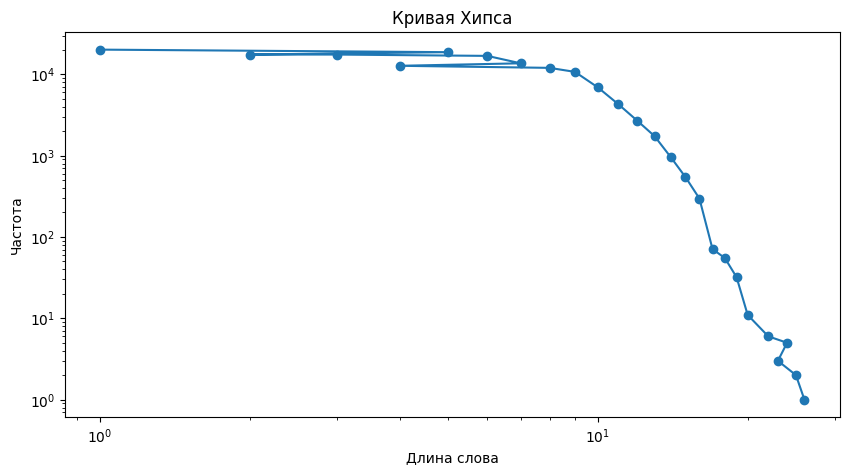

In [ ]:
# Построение кривой Хипса
plt.figure(figsize=(10, 5))
plt.loglog([x[0] for x in sorted_lengths], [x[1] for x in sorted_lengths], marker='o')
plt.title('Кривая Хипса')
plt.xlabel('Длина слова')
plt.ylabel('Частота')
plt.show()

5. Ответьте на следующие вопросы:
*   какое слово встречается чаще, "сотрудник" или "клиент"?
*   сколько раз встречается слова "мошенничество" и "доверие"?

In [ ]:
# Выводим частоту слов "сотрудник" и "клиент"
print("Слово 'сотрудник' встречается", word_counts['сотрудник'], "раз.")
print("Слово 'клиент' встречается", word_counts['клиент'], "раз.")

# Выводим частоту слов "мошенничество" и "доверие"
print("Слово 'мошенничество' встречается", word_counts['мошенничество'], "раз.")
print("Слово 'доверие' встречается", word_counts['доверие'], "раз.")

Слово 'сотрудник' встречается 153 раз.
Слово 'клиент' встречается 101 раз.
Слово 'мошенничество' встречается 8 раз.
Слово 'доверие' встречается 17 раз.


6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру, для того, чтобы найти ключевые слова и биграмы для положительных отзывов
(с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [ ]:
positive_reviews = df[df['rating_grade'] == 5]['text']
negative_reviews = df[df['rating_grade'] == 1]['text']

In [ ]:
positive_reviews.info()

<class 'pandas.core.series.Series'>
Index: 14713 entries, 98 to 153498
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
14713 non-null  object
dtypes: object(1)
memory usage: 229.9+ KB


In [ ]:
positive_reviews.head()

98     Досрочно закрывали вклады перед отпуском. Жена...
122    Хотел открыть вклад "Доходный+" под 19% год , ...
157    Вчера, 3 июня, просидев в очереди более 3-х ча...
259    Сегодня открывал вклад в этом банке. Очередь б...
266    Моя история получения кредита в Ренессанс Кред...
Name: text, dtype: object

In [ ]:
negative_reviews.info()

<class 'pandas.core.series.Series'>
Index: 47387 entries, 19 to 153497
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
47387 non-null  object
dtypes: object(1)
memory usage: 740.4+ KB


In [ ]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
positive_words = [preprocess(review) for review in positive_reviews]
negative_words = [preprocess(review) for review in negative_reviews]

In [ ]:
from nltk.util import ngrams

def get_top_ngrams(words, n=2, top_n=5):
    freq_dist = nltk.FreqDist(ngrams(words, n))
    return freq_dist.most_common(top_n)

positive_bigrams = [get_top_ngrams(words.split()) for words in positive_words]
negative_bigrams = [get_top_ngrams(words.split()) for words in negative_words]


In [ ]:
positive_bigrams[:4]

[[(('досрочно', 'закрывать'), 1),
  (('закрывать', 'вклад'), 1),
  (('вклад', 'отпуск'), 1),
  (('отпуск', 'жена'), 1),
  (('жена', 'заказывать'), 1)],
 [(('вклад', 'доходный'), 3),
  (('счет', 'вклад'), 3),
  (('открывать', 'вклад'), 2),
  (('месяц', 'месяц'), 2),
  (('первоначальный', 'взнос'), 2)],
 [(('вчера', 'июнь'), 1),
  (('июнь', 'просиживать'), 1),
  (('просиживать', 'очередь'), 1),
  (('очередь', 'х'), 1),
  (('х', 'час'), 1)],
 [(('отмечать', 'наличие'), 2),
  (('сегодня', 'открывать'), 1),
  (('открывать', 'вклад'), 1),
  (('вклад', 'это'), 1),
  (('это', 'банк'), 1)]]

In [ ]:
negative_bigrams[:4]

[[(('зарплатный', 'карта'), 2),
  (('карта', 'рубль'), 2),
  (('долларовый', 'сч'), 2),
  (('подтверждение', 'операция'), 2),
  (('сч', 'карта'), 2)],
 [(('одобрять', 'кредит'), 3),
  (('одобрять', 'банк'), 3),
  (('пояснять', 'страховка'), 2),
  (('страховка', 'сотрудник'), 2),
  (('выдавать', 'одобрять'), 2)],
 [(('процентный', 'ставка'), 2),
  (('договор', 'указывать'), 2),
  (('дополнительный', 'взнос'), 2),
  (('около', 'час'), 1),
  (('час', 'приходить'), 1)],
 [(('счет', 'находить'), 2),
  (('оплата', 'коммунальный'), 1),
  (('коммунальный', 'платеж'), 1),
  (('платеж', 'пользоваться'), 1),
  (('пользоваться', 'пластиковый'), 1)]]

Часть 2. Тематическое моделирование


*   Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
*   Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.




In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import TfidfModel
from gensim import similarities
from gensim.utils import simple_preprocess # Преобразование документов в список слов

In [ ]:
tokenized_documents = [simple_preprocess(doc) for doc in df_text.text] #равносильно texts = [text.split() for text in df.text]
dictionary = Dictionary(tokenized_documents) #создание словоря
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents] # Преобразование документов в векторы


In [ ]:
# Построение тематической модели
num_topics = 5 # Количество тем для каждого набора документов
lda_model = LdaModel(corpus, id2word=dictionary, passes=5) #num_topics=num_topics,

In [ ]:
# 10 наиболее значимых тем
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)


(21, '0.026*"сергея" + 0.021*"продуктах" + 0.021*"правления" + 0.015*"председателю" + 0.010*"анатольевича" + 0.010*"нов" + 0.009*"вячеслав" + 0.007*"неприятности" + 0.007*"ух" + 0.003*"викторию"')
(79, '0.037*"тинькофф" + 0.024*"retail" + 0.017*"back" + 0.015*"rus" + 0.015*"cash" + 0.011*"билетов" + 0.011*"авиабилетов" + 0.010*"бронирования" + 0.009*"moscow" + 0.009*"авиакомпании"')
(47, '0.065*"кредит" + 0.036*"страхования" + 0.036*"кредита" + 0.033*"что" + 0.029*"страховки" + 0.024*"от" + 0.022*"мы" + 0.020*"страховку" + 0.020*"на" + 0.017*"страховка"')
(56, '0.037*"связного" + 0.026*"кнопки" + 0.024*"приложить" + 0.012*"сберегательный" + 0.011*"навязан" + 0.010*"обеду" + 0.007*"объективных" + 0.006*"ор" + 0.006*"il" + 0.006*"поднялась"')
(72, '0.023*"выданы" + 0.015*"минусе" + 0.014*"вэб" + 0.012*"глазам" + 0.011*"стаж" + 0.009*"делах" + 0.008*"истекло" + 0.006*"трехсот" + 0.005*"пожалели" + 0.005*"вокзала"')
(84, '0.027*"хххх" + 0.026*"ставки" + 0.018*"картам" + 0.017*"свидетельств

In [ ]:
lda_model.show_topics(5)

[(43,
  '0.035*"на" + 0.025*"не" + 0.018*"по" + 0.018*"что" + 0.010*"банка" + 0.010*"банк" + 0.009*"мне" + 0.007*"от" + 0.007*"меня" + 0.006*"договора"'),
 (95,
  '0.032*"не" + 0.028*"на" + 0.017*"что" + 0.012*"по" + 0.010*"деньги" + 0.010*"банк" + 0.009*"за" + 0.009*"через" + 0.008*"мне" + 0.008*"но"'),
 (5,
  '0.018*"что" + 0.017*"на" + 0.016*"мне" + 0.015*"не" + 0.014*"платежа" + 0.012*"рублей" + 0.010*"по" + 0.009*"втб" + 0.009*"кредит" + 0.008*"меня"'),
 (65,
  '0.005*"отсканировали" + 0.004*"соотв" + 0.004*"моментальное" + 0.003*"накоплено" + 0.003*"совершается" + 0.002*"марки" + 0.002*"моментальным" + 0.002*"нарушил" + 0.002*"cetelem" + 0.001*"др"'),
 (38,
  '0.027*"распоряжения" + 0.017*"симку" + 0.014*"пвн" + 0.011*"обновили" + 0.009*"незнакомого" + 0.009*"вернусь" + 0.007*"нарисовал" + 0.006*"обменный" + 0.006*"взаимопонимание" + 0.006*"депозитной"')]

In [ ]:
topics

[(21,
  '0.026*"сергея" + 0.021*"продуктах" + 0.021*"правления" + 0.015*"председателю" + 0.010*"анатольевича" + 0.010*"нов" + 0.009*"вячеслав" + 0.007*"неприятности" + 0.007*"ух" + 0.003*"викторию"'),
 (79,
  '0.037*"тинькофф" + 0.024*"retail" + 0.017*"back" + 0.015*"rus" + 0.015*"cash" + 0.011*"билетов" + 0.011*"авиабилетов" + 0.010*"бронирования" + 0.009*"moscow" + 0.009*"авиакомпании"'),
 (47,
  '0.065*"кредит" + 0.036*"страхования" + 0.036*"кредита" + 0.033*"что" + 0.029*"страховки" + 0.024*"от" + 0.022*"мы" + 0.020*"страховку" + 0.020*"на" + 0.017*"страховка"'),
 (56,
  '0.037*"связного" + 0.026*"кнопки" + 0.024*"приложить" + 0.012*"сберегательный" + 0.011*"навязан" + 0.010*"обеду" + 0.007*"объективных" + 0.006*"ор" + 0.006*"il" + 0.006*"поднялась"'),
 (72,
  '0.023*"выданы" + 0.015*"минусе" + 0.014*"вэб" + 0.012*"глазам" + 0.011*"стаж" + 0.009*"делах" + 0.008*"истекло" + 0.006*"трехсот" + 0.005*"пожалели" + 0.005*"вокзала"'),
 (84,
  '0.027*"хххх" + 0.026*"ставки" + 0.018*"картам

In [ ]:
banks = ["сбербанк", "втб", "другой банк", "альфа", 'вэб', 'тинькофф']

# Фильтрация тем по банкам
for i, topic in enumerate(topics):
    topic_words = topic[1]
    topic_words = re.sub(r'[+ 0-9*". ]',' ', topic_words)
    topic_words = topic_words.split()
    for word in topic_words:
        if word in banks:
            print(f"Тема {i+1}: {topic[0]}, {word}")




Тема 2: 79, тинькофф
Тема 5: 72, вэб
Тема 10: 53, сбербанк
Тема 20: 69, альфа


In [ ]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [ ]:
# %%time
index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

In [ ]:
len(corpus)

5000

In [ ]:
sims[0]

array([0.9999999 , 0.0067228 , 0.02123258, ..., 0.04188794, 0.02127748,
       0.01697107], dtype=float32)

In [ ]:
sims.shape

(5000, 5000)

In [ ]:
import seaborn as sns

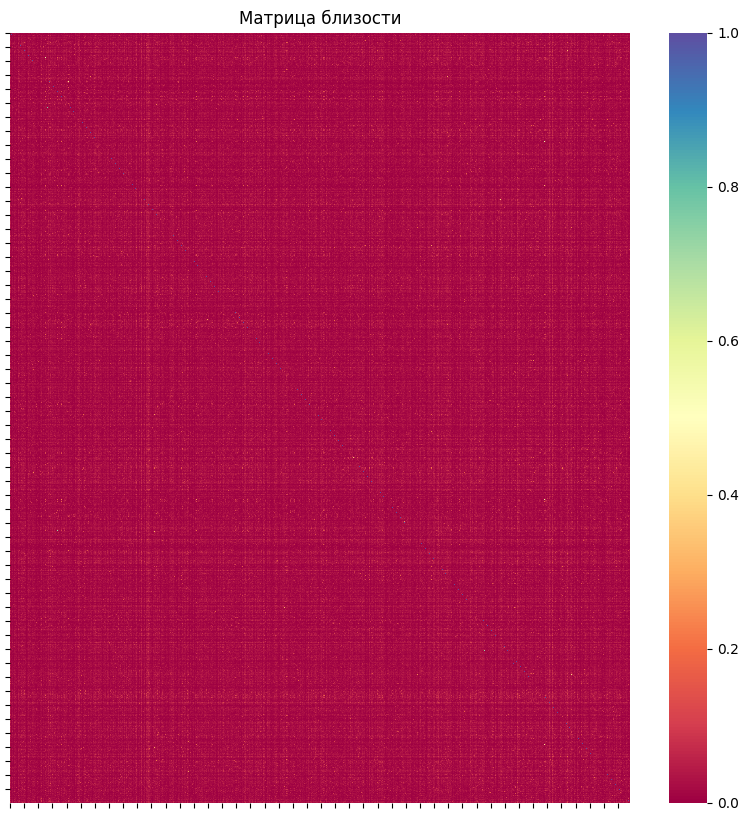

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])
plt.title("Матрица близости")
plt.show()
#для красоты, т.к. в данном примере она бесполезна

In [ ]:
from gensim.models import lsimodel

In [ ]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

CPU times: user 7.99 s, sys: 913 ms, total: 8.9 s
Wall time: 5.73 s


In [ ]:
lsi.show_topics(5)

[(0,
  '0.112*"мне" + 0.098*"деньги" + 0.096*"карты" + 0.094*"карту" + 0.090*"меня" + 0.089*"кредит" + 0.087*"то" + 0.085*"банк" + 0.084*"что" + 0.082*"банка"'),
 (1,
  '0.282*"звонки" + 0.219*"номер" + 0.185*"данных" + 0.182*"телефона" + 0.179*"персональных" + 0.172*"базы" + 0.169*"поступают" + 0.164*"удалить" + 0.163*"мой" + 0.160*"согласия"'),
 (2,
  '-0.230*"кредит" + 0.198*"карты" + 0.172*"карту" + 0.166*"банкомат" + -0.162*"кредита" + 0.161*"деньги" + -0.123*"страхования" + -0.115*"страховки" + 0.104*"сбербанка" + 0.102*"средств"'),
 (3,
  '-0.403*"вклада" + -0.336*"вклад" + -0.126*"условия" + -0.122*"вкладов" + -0.112*"вкладу" + -0.107*"ставка" + -0.103*"цб" + -0.102*"пополнения" + 0.091*"сбербанка" + -0.088*"рф"'),
 (4,
  '-0.177*"кредита" + -0.169*"страхования" + -0.152*"договора" + -0.134*"договор" + -0.134*"руб" + -0.117*"средств" + -0.115*"средства" + -0.113*"сумму" + -0.111*"кредит" + -0.109*"рублей"')]

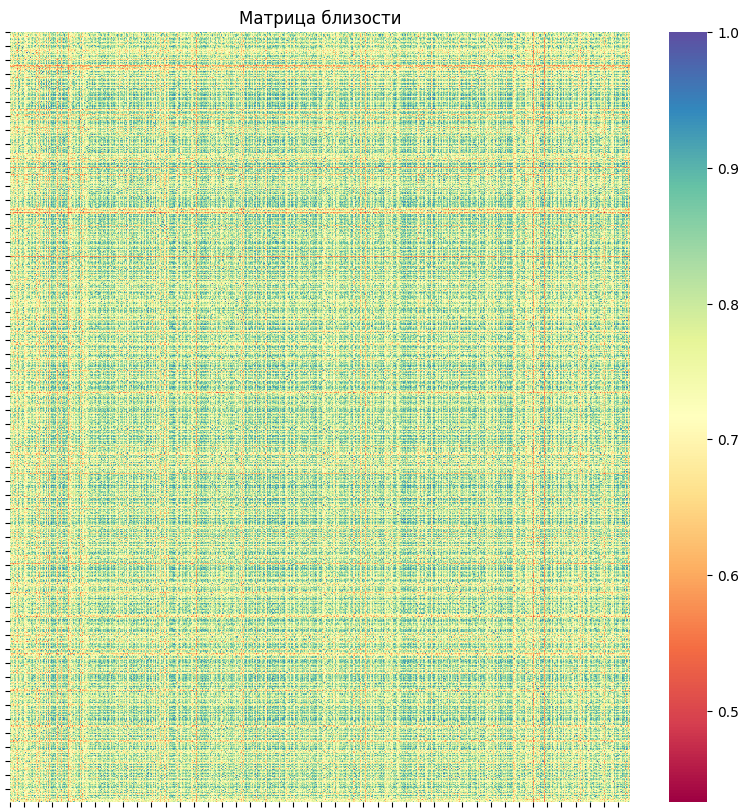

In [ ]:
#Как снижение размерности влияет на матрицу близости
corpus_lsi = lsi[corpus]
index = similarities.MatrixSimilarity(lsi[corpus])
sims = index[corpus_lsi]
sims  = (sims + 1)/2.
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()

**Часть 3. Классификация текстов**

1. Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

2. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных n-грам.
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
1-ый вариант:
 преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.



In [26]:
N2 = df[df['rating_grade'] == 5]
N1 = df[df['rating_grade'] == 1]

In [27]:
N = pd.concat([N1, N2])

In [29]:
N.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62100 entries, 19 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                50366 non-null  object 
 1   rating_not_checked  62100 non-null  bool   
 2   title               62100 non-null  object 
 3   num_comments        62100 non-null  int64  
 4   bank_license        62100 non-null  object 
 5   author              62092 non-null  object 
 6   bank_name           62100 non-null  object 
 7   datetime            62100 non-null  object 
 8   text                62100 non-null  object 
 9   rating_grade        62100 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 4.8+ MB


In [30]:
from nltk.tokenize import word_tokenize
from tqdm import tqdm

In [31]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [32]:
sentences = [word_tokenize(text.lower()) for text in tqdm(N.text)]

100%|██████████| 62100/62100 [03:36<00:00, 286.32it/s]


In [33]:
from gensim.models.word2vec import Word2Vec
%time model_text = Word2Vec(sentences, workers=6, vector_size=300, min_count=3, window=5, epochs=15)

CPU times: user 21min 36s, sys: 5.86 s, total: 21min 42s
Wall time: 12min 31s


In [34]:
model_text.wv.most_similar('втб')

[('бтб', 0.7169524431228638),
 ('тайнинская', 0.6869763135910034),
 ('vtb', 0.684184730052948),
 ('приват', 0.611294150352478),
 ('втб24', 0.5694069862365723),
 ('зиповская', 0.5654051899909973),
 ('тайнинской', 0.556291401386261),
 ('корп.4', 0.5143730640411377),
 ('внешторгбанк', 0.4901966154575348),
 ('кастанаевская', 0.48499372601509094)]

In [35]:
model_text.wv.most_similar('сбербанк')

[('ситибанк', 0.7190963625907898),
 ('сбер', 0.7128422260284424),
 ('альфа-банк', 0.6660673022270203),
 ('банк', 0.6371974349021912),
 ('росбанк', 0.5955294370651245),
 ('промсвязьбанк', 0.5897923707962036),
 ('бинбанк', 0.5676316618919373),
 ('мкб', 0.510856032371521),
 ('райффайзенбанк', 0.4867422878742218),
 ('россельхозбанк', 0.4866790473461151)]

In [36]:
model_text.init_sims()

<ipython-input-36-bac5e3c246a7>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model_text.init_sims()


In [37]:
def get_text_embedding(text):
    result = []
    for word in word_tokenize(text.lower()):
        if word in model_text.wv:
            result.append(model_text.wv[word])

    if len(result):
        result = np.sum(result, axis=0)
    else:
        result = np.zeros(300)
    return result

In [38]:
features = [get_text_embedding(text) for text in tqdm(N.text)]

100%|██████████| 62100/62100 [04:37<00:00, 223.39it/s]


In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation

In [54]:
X_train, X_test, y_train, y_test = train_test_split(features, N.rating_grade, test_size=0.2, random_state=42)

In [55]:
model = LogisticRegression()
model.fit(X_train, y_train, )

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [56]:
from sklearn.metrics import classification_report

In [57]:
predicted = model.predict(X_test)

In [58]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

         1.0       0.97      0.98      0.98      9383
         5.0       0.93      0.91      0.92      3037

    accuracy                           0.96     12420
   macro avg       0.95      0.94      0.95     12420
weighted avg       0.96      0.96      0.96     12420



In [60]:
vec = CountVectorizer()

In [61]:
bow = vec.fit_transform(N.text)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(bow, N.rating_grade, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [63]:
predicted = model.predict(X_test)

In [64]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

         1.0       0.97      0.98      0.98      9383
         5.0       0.95      0.91      0.93      3037

    accuracy                           0.97     12420
   macro avg       0.96      0.95      0.95     12420
weighted avg       0.97      0.97      0.97     12420



In [67]:
#Только униграммы
X = N['text'].tolist() # Преобразуем колонку в список строк
y = N['rating_grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vec = CountVectorizer(ngram_range=(1, 1))
X_train_unigrams = vec.fit_transform(X_train)
X_test_unigrams = vec.transform(X_test)

model_unigrams = LogisticRegression()
model_unigrams.fit(X_train_unigrams, y_train)
y_pred_unigrams = model_unigrams.predict(X_test_unigrams)
print(classification_report(y_test, y_pred_unigrams))


              precision    recall  f1-score   support

         1.0       0.97      0.98      0.98      9383
         5.0       0.95      0.91      0.93      3037

    accuracy                           0.97     12420
   macro avg       0.96      0.95      0.95     12420
weighted avg       0.97      0.97      0.97     12420



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [68]:
 #Униграммы, пары и троек слов
vec = CountVectorizer(ngram_range=(1, 3))
X_train_ngrams = vec.fit_transform(X_train)
X_test_ngrams = vec.transform(X_test)

model_ngrams = LogisticRegression()
model_ngrams.fit(X_train_ngrams, y_train)
y_pred_ngrams = model_ngrams.predict(X_test_ngrams)
print(classification_report(y_test, y_pred_ngrams))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

         1.0       0.97      0.99      0.98      9383
         5.0       0.96      0.91      0.93      3037

    accuracy                           0.97     12420
   macro avg       0.97      0.95      0.96     12420
weighted avg       0.97      0.97      0.97     12420



In [69]:
#Символьные n-граммы

vec = CountVectorizer(analyzer='char', ngram_range=(1, 3))
X_train_char_ngrams = vec.fit_transform(X_train)
X_test_char_ngrams = vec.transform(X_test)

model_char_ngrams = LogisticRegression()
model_char_ngrams.fit(X_train_char_ngrams, y_train)
y_pred_char_ngrams = model_char_ngrams.predict(X_test_char_ngrams)
print(classification_report(y_test, y_pred_char_ngrams))


              precision    recall  f1-score   support

         1.0       0.97      0.97      0.97      9383
         5.0       0.91      0.90      0.90      3037

    accuracy                           0.95     12420
   macro avg       0.94      0.93      0.94     12420
weighted avg       0.95      0.95      0.95     12420



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [71]:
# Обучение модели с использованием TF-IDF и TruncatedSVD
# Векторизация текста
vec = CountVectorizer()
X_train_counts = vec.fit_transform(X_train)
X_test_counts = vec.transform(X_test)

# Преобразование TF-IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Сингулярное разложение
svd = TruncatedSVD(n_components=10)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

# Обучение модели
model_svd = LogisticRegression()
model_svd.fit(X_train_svd, y_train)

# Предсказание на тестовой выборке
y_pred_svd = model_svd.predict(X_test_svd)
print(classification_report(y_test, y_pred_svd))

              precision    recall  f1-score   support

         1.0       0.92      0.97      0.95      9383
         5.0       0.88      0.76      0.82      3037

    accuracy                           0.92     12420
   macro avg       0.90      0.86      0.88     12420
weighted avg       0.91      0.92      0.91     12420



In [73]:
# Обучение модели с использованием LDA
# Тематическое моделирование LDA
lda = LatentDirichletAllocation(n_components=10)
X_train_lda = lda.fit_transform(X_train_counts)
X_test_lda = lda.transform(X_test_counts)

# Обучение модели
model_lda = LogisticRegression()
model_lda.fit(X_train_lda, y_train)

# Предсказание на тестовой выборке
y_pred_lda = model_lda.predict(X_test_lda)
print(classification_report(y_test, y_pred_lda))

              precision    recall  f1-score   support

         1.0       0.94      0.98      0.96      9383
         5.0       0.94      0.82      0.87      3037

    accuracy                           0.94     12420
   macro avg       0.94      0.90      0.92     12420
weighted avg       0.94      0.94      0.94     12420

